In [2]:
import kipoi
import kipoi_interpret
import numpy as np
import tensorflow as tf
from kipoi_veff.utils.plot import seqlogo_heatmap
from concise.preprocessing.sequence import encodeDNA
from kipoiseq.dataloaders import SeqIntervalDl
from matplotlib import pyplot as plt

<h1>list all available methods/models


In [3]:
#kipoi.list_models()
kipoi_interpret.importance_scores.available_methods()

{'mutation': kipoi_interpret.importance_scores.ism.Mutation,
 'saliency': kipoi_interpret.importance_scores.gradient.Saliency,
 'grad*input': kipoi_interpret.importance_scores.gradient.GradientXInput,
 'grad': kipoi_interpret.importance_scores.gradient.Gradient,
 'deeplift': kipoi_interpret.importance_scores.referencebased.DeepLift,
 'intgrad': kipoi_interpret.importance_scores.referencebased.IntegratedGradients}

<h1>Kipoi interpret models

In [4]:
# Import Kipoi interpret models

# Gradient-based methods
from kipoi_interpret.importance_scores.gradient import Gradient, GradientXInput
# In-silico mutagenesis-based methods
from kipoi_interpret.importance_scores.ism import Mutation
# DeepLift
from kipoi_interpret.importance_scores.referencebased import DeepLift

In [5]:
# Custom saliency models

class Saliency(Gradient):
    def score(self, input_batch):
        return np.abs(super(Saliency, self).score(input_batch))

<h1>Select Model</h1>

In [6]:
model = kipoi.get_model("DeepBind/Homo_sapiens/TF/D00765.001_ChIP-seq_GATA1")

Using downloaded and verified file: /Users/brandon/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/TF/D00765.001_ChIP-seq_GATA1/arch/d0bf8403d0cfe0037537f6f2e002f5b6
Using downloaded and verified file: /Users/brandon/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/TF/D00765.001_ChIP-seq_GATA1/weights/9155558f7b04004dd50daf5903c5a514


<h1>Single Example</h1>

(1, 101, 4)
Score shape (101, 4)


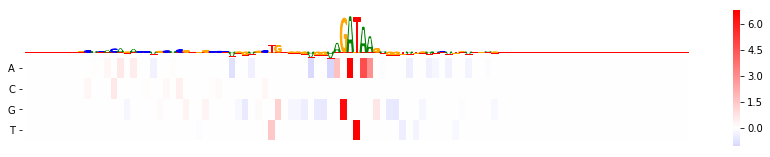

In [7]:
# Expected data shape for deepbind

# Encode sequence
seq = "ATGGGCCAGCACACAGACCAGCACGTTGCCCAGGAGCTGTGGGAGGAAGATAAGAGGTATGAACATGATTAGCAAAAGGGCCTAGCTTGGACTCAGAATAA"
seqa = encodeDNA([seq]) # one-hot-encode thesequence
print(seqa.shape)

# Calculate score
gradient = GradientXInput(model)
val = gradient.score(seqa)[0]
print('Score shape', val.shape)

# Score map
fig = plt.figure(figsize=(15,2.5))
seqlogo_heatmap(val, val.T, ax=plt.subplot())

<h1>Randomized Example</h1>

0.00B [00:00, ?B/s]

8.19kB [00:00, 39.8kB/s]                 
  0%|          | 0.00/300k [00:00<?, ?B/s]

303kB [00:00, 1.32MB/s]                   
/Users/brandon/miniconda3/envs/kipoi-shared__envs__kipoi-py3-keras2/lib/python3.6/site-packages/kipoiseq/dataloaders/sequence.py:87: FutureWarning: read_table is deprecated, use read_csv instead.
  sep='\t')
/Users/brandon/miniconda3/envs/kipoi-shared__envs__kipoi-py3-keras2/lib/python3.6/site-packages/kipoiseq/dataloaders/sequence.py:99: FutureWarning: read_table is deprecated, use read_csv instead.
  sep='\t')
100%|██████████| 1/1 [00:00<00:00, 86.00it/s]


Selecting indices [3 2 0 4 7]


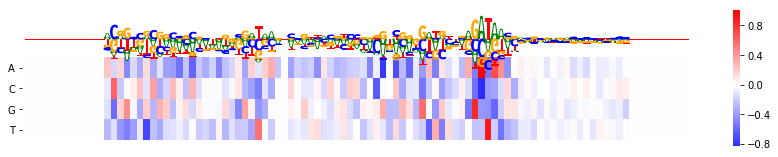

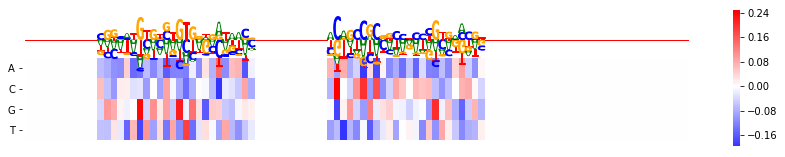

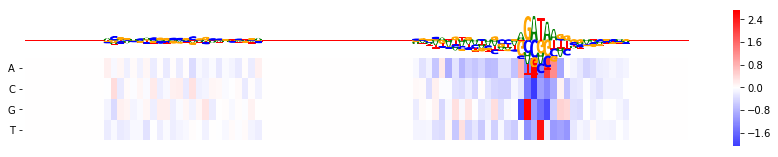

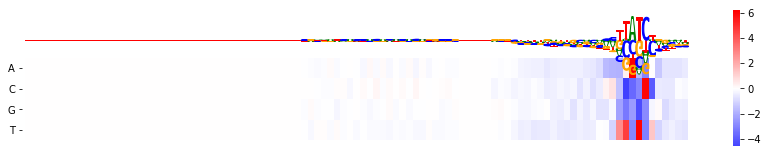

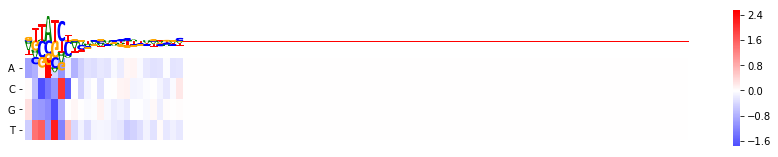

In [8]:
# get the example dataloader
dl_kwargs = model.default_dataloader.download_example('example')
dl = model.default_dataloader(**dl_kwargs)

# load all of the data
all = dl.load_all()  # load the whole dataset
data = all['inputs']
num_sequences_to_select = 5
indices = np.random.choice(data.shape[0], num_sequences_to_select, replace=False)  

# compute the gradients
gradient = Gradient(model)
print('Selecting indices', indices)
for x in indices:
    val = gradient.score(data[x:x+1,:,:])[0]
    fig = plt.figure(figsize=(15,2.5))
    seqlogo_heatmap(val, val.T, ax=plt.subplot())

<h1>Saliency Analysis</h1>

In [10]:
# Gather seq data
path = '/Users/brandon/research/kipoi_examples/nbt3300-code/data/dream5/chipseq'

import glob
import pandas as pd
allFiles = glob.glob(path + '/*100_genomic*.seq')
# allFiles = glob.glob(path + '/TF_23_CHIP_100*.seq')

list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,header=None, sep='\t')
    list_.append(df)

frame = pd.concat(list_, axis = 0, ignore_index = True)
print('Read data frame', frame.shape)
frame_ones = frame.loc[frame[1] == 1]
print('Ones', frame_ones.shape)

# Encode the sequences
seqs = frame[0]
print('Sequences shape', seqs.shape)
data = encodeDNA(seqs) # one-hot-encode thesequence
print('Encoded data shape', data.shape)

Read data frame (4992, 2)
Ones (2496, 2)
Sequences shape (4992,)
Encoded data shape (4992, 101, 4)


<h2>Model Randomization

In [8]:
print(model.name)
model.get_layers_and_outputs(use_final_layer=True)

DeepBind/Homo_sapiens/TF/D00765.001_ChIP-seq_GATA1


([<keras.layers.merge.Maximum at 0x1324e0eb8>],
 [<tf.Tensor 'maximum_593/Maximum:0' shape=(?,) dtype=float32>],
 [2])

In [9]:
km = model.model
print(km.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_841 (InputLayer)          (None, None, 4)      0                                            
__________________________________________________________________________________________________
lambda_2273 (Lambda)            (None, None, 4)      0           input_841[0][0]                  
__________________________________________________________________________________________________
lambda_2274 (Lambda)            (None, None, 4)      0           lambda_2273[0][0]                
__________________________________________________________________________________________________
conv1d_841 (Conv1D)             (None, None, 16)     1552        lambda_2273[0][0]                
                                                                 lambda_2274[0][0]                
__________

In [10]:
def score_with_method(method, data):
    scores = np.empty(data.shape)
    for x in range(len(data)):
        scores[x] = method.score(data[x:x+1,:,:])[0]
    return scores

from sklearn.metrics import mean_squared_error
def calculate_mse_scores(original_scores_3d, new_scores_3d):
    result = 0
    for i in range(len(original_scores_3d)):
        mse = mean_squared_error(original_scores_3d[i], new_scores_3d[i])
        result += mse
    return result

def save_weights(keras_model, weights):
    for i in range(len(weights)):
        keras_model.layers[i].set_weights(weights[i])

def to_array(isval):
    """Temporary convert the output to a numpy array
    """
    def to_vec(x):
        if x is None:
            return 0
        else:
            if isinstance(x, list):
                return x[0]
            else:
                return x
    return np.array([[to_vec(y) for y in x] for x in isval])

def get_random_and_current_weights(km):
    sess = tf.InteractiveSession()
    tf.initializers.global_variables().run()

    new_weights = [layer.get_weights() for layer in km.layers]
    original_weights = new_weights.copy()
    for l in range(len(new_weights)):
        layer = new_weights[l]
        if len(layer) > 0:
            for i in range(len(layer)):
                var_shape = layer[i].shape
                new_weights[l][i] = np.random.random(var_shape)    
    return new_weights, original_weights

<h2>Mean Squared Error Analysis</h2>

In [11]:
method = Gradient(model)
new_weights, original_weights = get_random_and_current_weights(model.model)
original_scores = score_with_method(method, data)
save_weights(model.model, new_weights)
new_scores = score_with_method(method, data)
save_weights(model.model, original_weights)

mse = calculate_mse_scores(original_scores, new_scores)
print('Total MSE:', mse)
print('Among %s datapoints: %s' % (len(data), mse/len(data)))

Total MSE: 7097.701306075262
Among 4992 datapoints: 1.4218151654798201


In [ ]:
method = GradientXInput(model)
new_weights, original_weights = get_random_and_current_weights(model.model)
original_scores = score_with_method(method, data)
save_weights(model.model, new_weights)
new_scores = score_with_method(method, data)
save_weights(model.model, original_weights)

mse = calculate_mse_scores(original_scores, new_scores)
print('Total MSE:', mse)
print('Among %s datapoints: %s' % (len(data), mse/len(data)))

In [12]:
method = Saliency(model)
new_weights, original_weights = get_random_and_current_weights(model.model)
original_scores = score_with_method(method, data)
save_weights(model.model, new_weights)
new_scores = score_with_method(method, data)
save_weights(model.model, original_weights)

mse = calculate_mse_scores(original_scores, new_scores)
print('Total MSE:', mse)
print('Among %s datapoints: %s' % (len(data), mse/len(data)))

Total MSE: 11181.598474101342
Among 4992 datapoints: 2.2399035404850443


In [25]:
from scipy.stats import spearmanr 
def spearman_rank(original, new):
    for i in range(len(original)):
        result = spearmanr(original[i], new[i], axis=None)
        print(result)
        break
print(spearman_rank(original_scores, new_scores))    

SpearmanrResult(correlation=-0.3472005371975818, pvalue=6.88775337761958e-13)
None


In [36]:
from scipy.spatial.distance import hamming
def hamming_distance(original, new):
    return hamming(original, new)

# print(hamming_distance(original_scores, new_scores))
A = ['A','B','C']
B = ['A','C','F']
print(hamming_distance(A, B))

ValueError: The 1d arrays must have equal lengths.

In [1]:
import kipoi
import kipoi_interpret
import numpy as np
import tensorflow as tf
from kipoi_veff.utils.plot import seqlogo_heatmap
from concise.preprocessing.sequence import encodeDNA
from kipoiseq.dataloaders import SeqIntervalDl
from matplotlib import pyplot as plt
model = kipoi.get_model("DeepBind/Homo_sapiens/TF/D00765.001_ChIP-seq_GATA1").model
sess = tf.InteractiveSession()
tf.initializers.global_variables().run()



---
Installed package 'kipoi=0.6.7' doesn't comply with 'kipoi>=0.6.9'
---
install or update the missing packages

Note: If you don't want to auto_update the model source, 
add `auto_update: False` to ~/.kipoi/config.yaml



/Users/brandon/miniconda3/envs/kipoi-shared__envs__kipoi-py3-keras2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/brandon/miniconda3/envs/kipoi-shared__envs__kipoi-py3-keras2/lib/python3.6/site-packages/kipoi_veff/external/concise/seqplotting_deps.py:34: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/Users/brandon/miniconda3/envs/kipoi-shared__envs__kipoi-py3-keras2/lib/python3.6/site-packages/kipoi_veff/external/concise/seqplotting_deps.py:35: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is dep

Using downloaded and verified file: /Users/brandon/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/TF/D00765.001_ChIP-seq_GATA1/arch/d0bf8403d0cfe0037537f6f2e002f5b6
Using downloaded and verified file: /Users/brandon/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/TF/D00765.001_ChIP-seq_GATA1/weights/9155558f7b04004dd50daf5903c5a514


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D

# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

import utils
import explanation as exp
import numpy as np
import similarity as sim

from vis.visualization import visualize_saliency, visualize_cam
from vis.utils import utils as vutils
from keras import activations
from matplotlib import pyplot as plt

# Gather seq data
path = '/Users/brandon/research/kipoi_examples/nbt3300-code/data/dream5/chipseq'

import glob
import pandas as pd
# allFiles = glob.glob(path + '/*100_genomic*.seq')
allFiles = glob.glob(path + '/TF_23_CHIP_100*.seq')

list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,header=None, sep='\t')
    list_.append(df)

frame = pd.concat(list_, axis = 0, ignore_index = True)
print('Read data frame', frame.shape)
frame_ones = frame.loc[frame[1] == 1]
print('Ones', frame_ones.shape)

# Encode the sequences
seqs = frame[0]
print('Sequences shape', seqs.shape)
x_test = utils.encodeDNA(seqs) # one-hot-encode thesequence
print('Encoded data shape', x_test.shape)

y_test = frame[1]

Read data frame (3000, 2)
Ones (1500, 2)
Sequences shape (3000,)
Encoded data shape (3000, 101, 4)


In [3]:
def explain_all(model, x, y, target=-1):
    import keras.backend as K
    with DeepExplain(session=K.get_session()) as de:
        input_tensor = model.layers[0].input
        fModel = Model(inputs=input_tensor, outputs = model.layers[target].output)
        target_tensor = fModel(input_tensor)

        xs = x[0:10]
        ys = y[0:10]

        attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys)
        attributions_sal = de.explain('saliency', target_tensor, input_tensor, xs, ys=ys)
        attributions_ig    = None
        attributions_dl    = None
        attributions_elrp  = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)
        attributions_occ   = de.explain('occlusion', target_tensor, input_tensor, xs, ys=ys)
        
        attributions_guided = []
        gbp = []
#         for i in range(len(xs)):
#             class_idx = np.nonzero(y[i])[0][0]
#             # guided backprop
#             gbp.append(visualize_saliency(model, -1, filter_indices=class_idx, 
#                                                    seed_input=xs[i], 
#                                                    backprop_modifier='guided'))
#             # guided gradcam
#             attributions_guided.append(visualize_cam(model, -1, filter_indices=class_idx, 
#                                                    seed_input=xs[i], 
#                                                    backprop_modifier='guided'))
#         attributions_guided = np.array(attributions_guided)
#         gbp = np.array(gbp)

        return attributions_gradin, attributions_sal, attributions_ig, attributions_dl, attributions_elrp, attributions_occ, gbp, attributions_guided

def cascade_random(model):
    og_gradin, og_sal, og_ig, og_dl, og_elrp, og_occ = explain_all(model, x_test, y_test, target=-1)
#     og = explain(model, x_test, y_test, target=-1)
    copy = utils.copy_model(model)
    for i in reversed(range(len(copy.get_weights()))):
        randomize_layer_weights(copy, i)
        gradin, sal, ig, dl, elrp, occ, gbp, guided = explain_all(copy, x_test, y_test, target=-1)
#         score = explain(copy, x_test, y_test, target=-1)
        print('gradin', sim.spearman_rank(gradin, og_gradin))
        print('gradin', sim.mse(gradin, og_gradin))
        print('sal', sim.spearman_rank(sal, og_sal))
        print('sal', sim.mse(sal, og_sal))
        print('elrp', sim.spearman_rank(elrp, og_elrp))
        print('elrp', sim.mse(elrp, og_elrp))
        print('occ', sim.spearman_rank(occ, og_occ))
        print('occ', sim.mse(occ, og_occ))
        
def random(model):
    og_gradin, og_sal, og_ig, og_dl, og_elrp, og_occ, og_gbp, og_guided = explain_all(model, x_test, y_test, target=-1)
    copy = utils.copy_model(model)
    for i in reversed(range(len(copy.get_weights()))):
        randomize_layer_weights(copy, i)
    gradin, sal, ig, dl, elrp, occ, gbp, guided = explain_all(copy, x_test, y_test, target=-1)
    print('gradin', sim.spearman_rank(gradin, og_gradin))
    print('gradin', sim.mse(gradin, og_gradin))
    print('sal', sim.spearman_rank(sal, og_sal))
    print('sal', sim.mse(sal, og_sal))
    print('ig', sim.spearman_rank(ig, og_ig))
    print('ig', sim.mse(ig, og_ig))
    print('elrp', sim.spearman_rank(elrp, og_elrp))
    print('elrp', sim.mse(elrp, og_elrp))
    print('occ', sim.spearman_rank(occ, og_occ))
    print('occ', sim.mse(occ, og_occ))
    print('guided', sim.spearman_rank(guided, og_guided))
    print('guided', sim.mse(guided, og_guided))
    print('gbp', sim.spearman_rank(gbp, og_gbp))
    print('gbp', sim.mse(gbp, og_gbp))
            
def randomize_layer_weights(model, layer_index): 
    from keras.initializers import glorot_uniform  # Or your initializer of choice
    import keras.backend as K

    weights = model.get_weights()

    backend_name = K.backend()
    if backend_name == 'tensorflow': 
        k_eval = lambda placeholder: placeholder.eval(session=K.get_session())
    elif backend_name == 'theano': 
        k_eval = lambda placeholder: placeholder.eval()
    else: 
        raise ValueError("Unsupported backend")
    
    layer_weights = weights[layer_index]
    weights[layer_index] = k_eval(glorot_uniform()(layer_weights.shape))

    model.set_weights(weights)

# cascade_random(model)
random(model)

AttributeError: module 'tensorflow.python.keras.models' has no attribute 'clone_model'